In [112]:
import os
import sys
import glob
import numpy as np
import pandas as pd

import scipy.io.wavfile

%matplotlib inline
import matplotlib.pyplot as plt

import util_cochlear_model

pd.set_option('display.max_rows', 100)


In [90]:
df = pd.read_csv('data/mturk_experiment_1_results_interspeech2021.csv')
# df = pd.read_csv('data/mturk_experiment_2_results_interspeech2021.csv')

df_tmp = df.groupby(['model', 'snr']).agg({"naturalness": ["count", "mean", "sem"]}).reset_index()
df_tmp['model'].unique()


array(['pretrained_germain', 'unet_A1', 'unet_A123', 'unet_A123W123',
       'unet_A1W1', 'unet_R1', 'unet_R123', 'unet_W1', 'unet_W123',
       'unet_W1T1', 'unet_cochlear_envelopes', 'unet_cochlear_human',
       'unet_germain_deep_features', 'unet_waveform', 'unprocessed_input',
       'wavenet_waveform'], dtype=object)

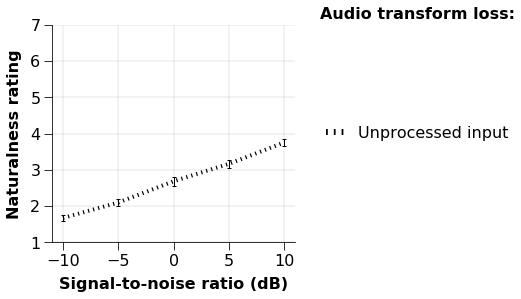

In [91]:
list_model = [
#     'unet_cochlear_human',
#     'unet_A123',
#     'unet_waveform',
#     'unet_R123',
    
#     'unet_cochlear_human',
#     'unet_cochlear_linear',
#     'unet_cochlear_reverse',
#     'unet_cochlear_human_n05',
#     'unet_cochlear_human_n10',
#     'unet_cochlear_human_n20',
#     'unet_cochlear_human_n80',
    
    'unprocessed_input',
]

map_kwargs_plot_update = {
#     'unet_A123': {'label': 'AudioSet deep\nfeatures', 'color': '#7570b3', 'ls': '-'},
#     'unet_R123': {'label': 'Random deep\nfeatures', 'color': '#e7298a', 'ls': '-'},
#     'unet_cochlear_human': {'label': 'Cochlear model', 'color': '#d95f02', 'ls': '-', 'zorder':10},
#     'unet_waveform': {'label': 'Waveform', 'color': '#1b9e77', 'ls': '-'},
#     'unprocessed_input': {'label': 'Unprocessed input', 'color': 'k', 'ls': '--', 'dashes': (0.3, 1)},
    
    'unet_cochlear_human': {'label': 'Cochlear model with\nhuman freq. tuning', 'color': '#d95f02', 'ls': '-'},
    'unet_cochlear_linear': {'label': 'Cochlear model with\nlinear freq. tuning', 'color': '#e78ac3', 'ls': '-'},

    'unet_cochlear_reverse': {'label': 'Cochlear model with\nreversed freq. tuning', 'color': '#66c2a5', 'ls': '-'},
#     'unet_cochlear_human_n05': {'label': 'Cochlear model\n(only 5 freq. channels)', 'color': 'b', 'ls': '-', 'zorder':10},

    'unprocessed_input': {'label': 'Unprocessed input', 'color': 'k', 'ls': '--', 'dashes': (0.3, 1)},}

fig, ax_arr = plt.subplots(figsize=(8,4), nrows=1, ncols=2, gridspec_kw={'width_ratios': [3,2]})
ax = ax_arr[0]

for model in list_model:
    df_tmp_tmp = df_tmp[df_tmp['model'] == model]
    x = df_tmp_tmp['snr'].values
    y = df_tmp_tmp['naturalness']['mean'].values
    yerr = df_tmp_tmp['naturalness']['sem'].values
    kwargs_plot = {
        'yerr': yerr,
        'label': model,
        'lw': 4,
        'elinewidth': 1,
        'capsize': 2,
    }
    kwargs_plot.update(map_kwargs_plot_update.get(model, {}))
    ax.errorbar(x, y, **kwargs_plot)

ax.set_xlim([-11, 11])
ax.set_ylim([1, 7])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xlabel('Signal-to-noise ratio (dB)', fontsize=16, labelpad=8, fontweight='bold')
ax.set_ylabel('Naturalness rating', fontsize=16, labelpad=8, fontweight='bold')

major_tick_params_kwargs = {
    'axis': 'both',
    'which': 'major',
    'labelsize': 16,
    'length': 8,
    'direction': 'out',
}
ax.tick_params(**major_tick_params_kwargs)
ax.grid(linewidth=0.1, color='k')
for spine_key in ['top', 'right']:
    ax.spines[spine_key].set_visible(False)

for spine_key in ['top', 'right', 'bottom', 'left']:
    ax_arr[1].spines[spine_key].set_visible(False)
ax_arr[1].set_xticks([])
ax_arr[1].set_yticks([])

legend_kwargs = {
    'loc': 'center',
    'borderpad': 0,
    'borderaxespad': 0,
    'handletextpad': 0.8,
    'frameon': False,
    'handlelength': 1.2,
    'markerscale': 1.0,
    'fontsize': 16,
    'labelspacing': 1.2
}

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
leg = ax_arr[1].legend(handles, labels, **legend_kwargs)
for legobj in leg.legendHandles:
    legobj.set_linewidth(6)

ax_arr[1].set_title('Audio transform loss:', fontsize=16, fontweight='bold')

plt.show()


[make_cos_filters_nx] using filter_spacing=`linear`


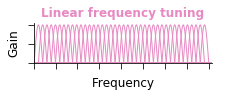

In [89]:

# str_title='Human frequency tuning'; color='#d95f02'; filter_spacing='erb'
str_title='Linear frequency tuning'; color='#e78ac3'; filter_spacing='linear'
# str_title='Reversed frequency tuning'; color='#66c2a5'; filter_spacing='erb_r'

filts, center_freqs, freqs = util_cochlear_model.make_cos_filters_nx(
    signal_length=40000,
    sr=20000,
    n=40,
    low_lim=20,
    hi_lim=8000,
    sample_factor=1,
    padding_size=None,
    full_filter=False,
    strict=True,
    bandwidth_scale_factor=1.0,
    include_lowpass=False,
    include_highpass=False,
    filter_spacing=filter_spacing)

fig, ax = plt.subplots(figsize=(3.2, 0.75))

for itr_ch in range(filts.shape[1]):
    kwargs_plot = {
        'color': color,
        'lw': 1.0,
    }
    ax.plot(freqs, filts[:, itr_ch], **kwargs_plot)

ax.set_xlim([0, 8000*1.02])
ax.set_ylim([0, 1.06])
ax.set_xticks(np.arange(0, 8001, 1000))
ax.set_yticks(np.arange(0, 1.01, 0.5))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Gain', fontsize=12)

major_tick_params_kwargs = {
    'axis': 'both',
    'which': 'major',
    'length': 6,
    'direction': 'out',
}
ax.tick_params(**major_tick_params_kwargs)

for spine_key in ['top', 'right']:
    ax.spines[spine_key].set_visible(False)
    
ax.set_title(str_title, fontsize=12, fontweight='bold', color=color)

plt.show()


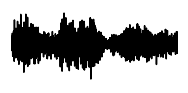

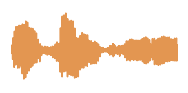

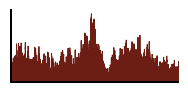

In [224]:
sr, y0 = scipy.io.wavfile.read(glob.glob('ex*_modelUnprocessedInput.wav')[0])
sr, y1 = scipy.io.wavfile.read(glob.glob('ex*_modelA123.wav')[0])
t = np.arange(0, y0.shape[0]) / sr

IDX = np.logical_and(t > 0.6, t<=1.2)
y0 = y0[IDX]
y1 = y1[IDX]
t = t[IDX]
dist_y = np.abs(y1 - y0)

figsize = (9/3, 4/3)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, y0, color=np.array([0, 0, 0]) / 256)
ax.set_xlim([t[0], t[-1]])
ax.set_xticks([])
ax.set_yticks([])
for spine_key in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine_key].set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(t, y1, color=np.array([228, 151, 81]) / 256)
ax.set_xlim([t[0], t[-1]])
ax.set_xticks([])
ax.set_yticks([])
for spine_key in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine_key].set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=figsize)
ax.fill_between(t, dist_y, y2=0, color=np.array([109, 30, 20]) / 256)
ax.set_xlim([t[0], t[-1]])
ax.set_ylim([0, None])
ax.set_xticks([])
ax.set_yticks([])
for spine_key in ['top', 'right']:
    ax.spines[spine_key].set_visible(False)
for spine_key in ['left', 'bottom']:
    ax.spines[spine_key].set_linewidth(2)
plt.show()


In [222]:
sr, y0 = scipy.io.wavfile.read(glob.glob('ex*_modelUnprocessedInput.wav')[0])
sr, y1 = scipy.io.wavfile.read(glob.glob('ex*_modelA123.wav')[0])

np.random.seed(858)

act_y0 = []
act_y1 = []

for _ in range(200):
    IDX = np.random.randint(0, 40000, size=[5])
    act_y0.append( np.abs(y0[IDX]).sum() )
    act_y1.append( np.abs(y1[IDX]).sum() )
act_y0 = np.array(act_y0)
act_y1 = np.array(act_y1)
dist_y = np.abs(act_y0-act_y1)
t = np.arange(0, len(act_y0))


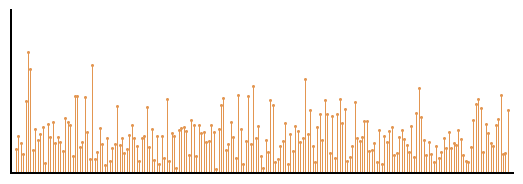

In [223]:
color = np.array([228, 151, 81]) / 256
y = act_y1
# color = 'k'
# y = act_y0
# color = np.array([109, 30, 20]) / 256
# y = dist_y

fig, ax = plt.subplots(figsize=(9, 3), nrows=1, ncols=1)

markerline, stemlines, baseline = plt.stem(t, y, markerfmt='.')
plt.setp(baseline, 'color', 'k')
plt.setp(markerline, 'color', color)
plt.setp(markerline, 'markersize', 4)
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linewidth', 1)

ax.set_xlim([t[0]-2, t[-1]+2])
ax.set_ylim([0, np.max([act_y0.max(), act_y1.max()])])
ax.set_xticks([])
ax.set_yticks([])
for spine_key in ['top', 'right']:
    ax.spines[spine_key].set_visible(False)
for spine_key in ['left', 'bottom']:
    ax.spines[spine_key].set_linewidth(2)

plt.show()
